# <h1><center> Homework 2 Assignment </center></h1>
### <h2><center> Computer Music Representations and Models Course </center></h2>
#### <h3><center> Acoustics Engineering @ Politecnico di Milano </center></h3>
##### Paolo Ostan, paolo.ostan@mail.polimi.it
#####           Stefano Donà, stefano2.dona@mail.polimi.it


In [4]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
import csv

## Question 1

Implementation of _template based chord recognition function_. 
Given an audio file, and some control parameters as input of the function, it is extrapolating the chord sequence using a Template-Based Pattern Matching algorithm

In [5]:
#creation of the main chord templates for the recognition algorithm 
template_cmaj = np.array([[1,0,0,0,1,0,0,1,0,0,0,0]]).T
template_cmin = np.array([[1,0,0,1,0,0,0,1,0,0,0,0]]).T

In [6]:
#function that generates a template matrix shifting chords pattern (e.g. C_maj, C_min...) in all 12 keys. 
# the function expects a matrix of dimensions (12,n) containing n possibile patterns  
def generate_template_matrix(templates):
    template_matrix = np.zeros((12,12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates,shift, axis = 0)
    return template_matrix

([<matplotlib.axis.XTick at 0x275ee614460>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C#'),
  Text(2, 0, 'D'),
  Text(3, 0, 'D#'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'F#'),
  Text(7, 0, 'G'),
  Text(8, 0, 'G#'),
  Text(9, 0, 'A'),
  Text(10, 0, 'A#'),
  Text(11, 0, 'B'),
  Text(12, 0, 'C:min'),
  Text(13, 0, 'C#:min'),
  Text(14, 0, 'D:min'),
  Text(15, 0, 'D#:min'),
  Text(16, 0, 'E:min'),
  Text(17, 0, 'F:min'),
  Text(18, 0, 'F#:min'),
  Text(19, 0, 'G:min'),
  Text(20, 0, 'G#:min'),
  Text(21, 0, 'A:min'),
  Text(22, 0, 'A#:min'),
  Text(23, 0, 'B:min')])

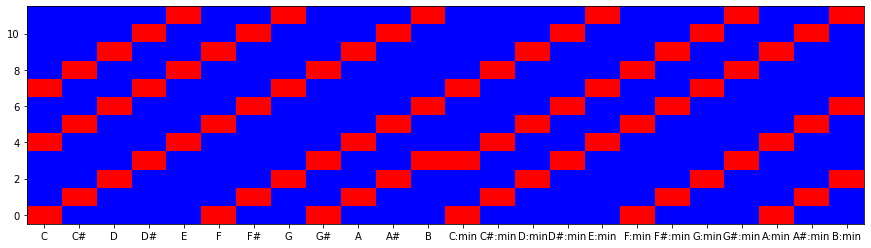

In [7]:
templates = generate_template_matrix(np.concatenate((template_cmaj,template_cmin), axis = 1))

plt.figure(figsize=(15,4))
plt.imshow(templates, origin="lower", aspect = "auto", cmap = "bwr")

chroma_labels = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
chroma_labels_maj = chroma_labels
chroma_labels_min = [s+':min' for s in chroma_labels]
chroma_labels = np.concatenate((chroma_labels_maj, chroma_labels_min), axis = 0)
plt.xticks(np.arange(24), chroma_labels)

In [8]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X: Feature sequence
        norm: The norm to be applied. '1', '2', 'max'
        threshold: An+ threshold below which the vector `v` used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm

    Returns:
        X_norm: Normalized feature sequence
    """
    
    K, N = X.shape
    X_norm = np.zeros((K,N))

    # Manhattan Norm
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.sum(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
                
    # Euclidean Norm
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in np.arange(N):
            p = np.sqrt(np.sum(X[:,n]**2))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v   
    
    # Maximum Norm
    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.max(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v

    return X_norm

In [9]:
from scipy import signal

def smooth_downsample_feature_sequence(X, Fs, filt_len = 41, down_sampling = 10, w_type = 'boxcar'):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
        
    Hint: use numpy expand dims to obtain a window of dimension (1, L)
    """
    
    filter_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth =  signal.convolve(X, filter_kernel, mode='same') / filt_len 
    
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_down = Fs / down_sampling
    
    return X_smooth, Fs_down

In [10]:
def analysis_template_match(chromagram, templates, Fs = 22050, hop_length = 2048, norm_chromagram = '2', norm_output ='2', 
                            smoothing_window_length = None, smoothing_down_sampling = None, window_type = 'boxcar'):
    """
    Args:
        chromagram:  Chromagram matrix 
        templates:  Matrix containing the chroma values of all the possible applicable templates 
        Fs:  Frame rate of `chromagram`
        hop_length:  Size of hops 
        norm_chromagram:  Type of normalization applied on chromagram, possible values: "1","2","max"
        norm_output:  Type of normalization applied on chord_similarity, possible values: "1","2","max"
        smoothing_window_length:  Length of smoothing filter 
        smoothing_down_sampling:  Downsampling factor 
        window_type:  Window type of smoothing filter

    Returns:
        chord_similarity: matrix where each box contains the value of similarity between the time quantum analyzed 
                          and the chord considered from templates matrix
        chord_max_labels: boolean matrix containing the containing in each column all the possible templates applied,
                          1 the box represents the most similar template applicable to the temporal quantum, 
                          0 otherwise
                          if more than box per column contains 1 the quantum can be considered containing silence 
        Fs_feature: Frame rate of chroma Matrices returned 
        
    """
    
    chromagram_normalized = normalize_feature_sequence(chromagram, norm_chromagram)
    H = hop_length
    Fs_chroma = Fs / H
    
    if smoothing_down_sampling and smoothing_window_length:
        chromagram_normalized, Fs_feature = smooth_downsample_feature_sequence(chromagram_normalized, Fs_chroma,
                                                                           down_sampling = smoothing_down_sampling,
                                                                          filt_len = smoothing_window_length,
                                                                          w_type = window_type)
    else:
        Fs_feature = Fs / H 
        
    template_normalized = normalize_feature_sequence(templates,    
                                                     norm = norm_chromagram)
    
    chord_similarity = np.matmul(template_normalized.T, chromagram_normalized)
    
    if norm_output:
        chord_similarity = normalize_feature_sequence(chord_similarity, norm = norm_output)
        
    chord_max_labels = (chord_similarity == chord_similarity.max(axis = 0)).astype(int) #boolean matrix
    
    
    return chord_similarity, chord_max_labels, Fs_feature


In [11]:
def computeChordListEval(filePath, Fs=22050, N=4096, H=2048, smoothing_window_length = None, smoothing_down_sampling = None, window_type = 'boxcar', norm_chromagram = '2', norm_output = 'max'):
    """
    Args:
        filePath: Path of the file to load to apply template-based recognition
        Fs: Frame rate at which the audio file is loaded
        N: FFT window size
        H: Hop length of chromagram 
        smoothing_window_length: Length of smoothing filter 
        smoothing_down_sampling: Downsampling factor
        window_type: Window type of smoothing filter
        norm_chromagram: Type of normalization applied on input chromagram, possible values: "1","2","max"
        norm_output: Type of normalization applied on chord_sim, possible values: "1","2","max"

    Returns:
        chordList: list of chord labels, where each chord, belonging to frame "n" is the most fitting template value according
                   to template-based chord recognition algorithm 
        Fs_feature: Fs_feature: Frame rate of frame based  chord recognition algorithm 
        chord_similarity: matrix where each box contains the value of similarity between the time quantum analyzed 
                          and the chord considered from templates matrix
        chord_max_labels: boolean matrix containing the containing in each column all the possible templates applied,
                          1 the box represents the most similar template applicable to the temporal quantum, 
                          0 otherwise
                          if more than box per column contains 1 the quantum can be considered containing silence 
         
        
    """
    x,Fs = librosa.load(filePath, sr=Fs)
    X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
    X = np.abs(X)**2
    C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)
    
    chord_sim, chord_max, Fs_feature = analysis_template_match(C, templates, 
                                                  Fs = Fs,
                                                  hop_length = H,
                                                  smoothing_window_length = smoothing_window_length, 
                                                  smoothing_down_sampling = smoothing_down_sampling,
                                                  window_type = window_type,
                                                  norm_chromagram = norm_chromagram, 
                                                  norm_output = norm_output)
    K, N = chord_max.shape
    chordList = []
    for i in np.arange(N):
        pos = chord_max[:,i]
        maxPos = np.where(pos != 0)
        if maxPos[0].size == 1:
            chordList.append(chroma_labels[maxPos[0].item(0)])
        elif maxPos[0].size == 0:
            raise Exception("The algorithm has something wrong and can't find any value ")
        else:
            chordList.append("random")
    
    return chordList, Fs_feature, chord_sim, chord_max

([<matplotlib.axis.YTick at 0x275eee12370>,
 [Text(0, 0, 'C'),
  Text(0, 1, 'C#'),
  Text(0, 2, 'D'),
  Text(0, 3, 'D#'),
  Text(0, 4, 'E'),
  Text(0, 5, 'F'),
  Text(0, 6, 'F#'),
  Text(0, 7, 'G'),
  Text(0, 8, 'G#'),
  Text(0, 9, 'A'),
  Text(0, 10, 'A#'),
  Text(0, 11, 'B'),
  Text(0, 12, 'C:min'),
  Text(0, 13, 'C#:min'),
  Text(0, 14, 'D:min'),
  Text(0, 15, 'D#:min'),
  Text(0, 16, 'E:min'),
  Text(0, 17, 'F:min'),
  Text(0, 18, 'F#:min'),
  Text(0, 19, 'G:min'),
  Text(0, 20, 'G#:min'),
  Text(0, 21, 'A:min'),
  Text(0, 22, 'A#:min'),
  Text(0, 23, 'B:min')])

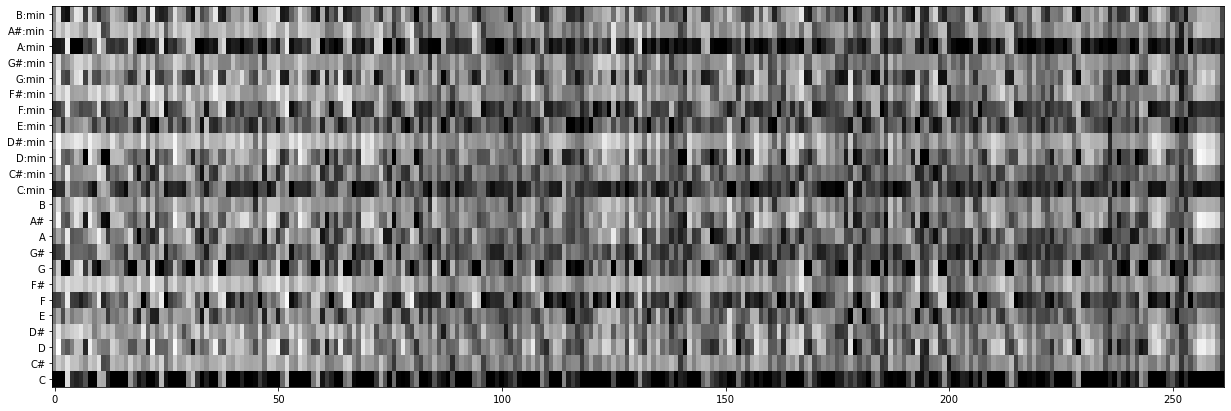

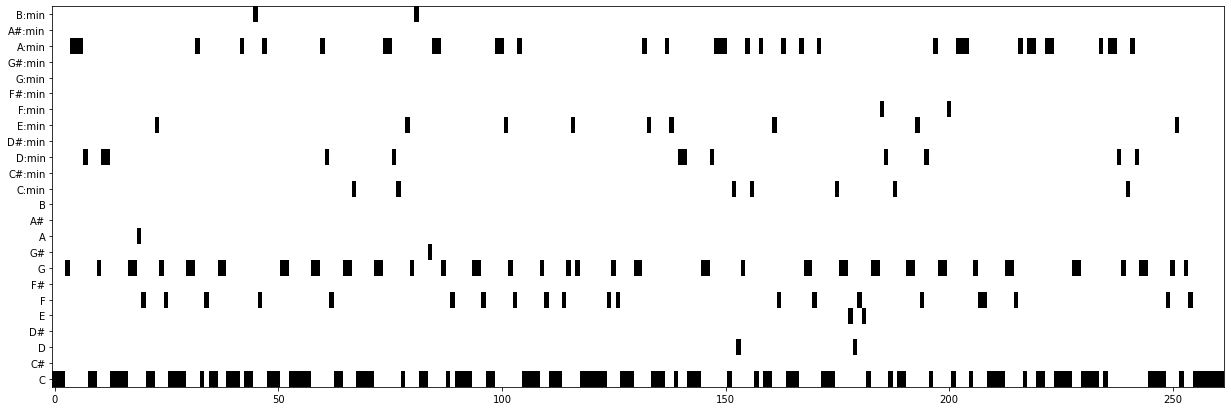

In [12]:
# TEST CHECK ON LET IT BE
fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')

chordList, Fs_feature, chord_sim, chord_max = computeChordListEval(fn_wav, smoothing_down_sampling = 10, smoothing_window_length = 10)

fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_sim, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)

fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_max, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)


## Question 2
    
In this section is proposed a method to load a .csv file containing the list of chords used to execute a song and strip this list into another. This last list will contain a simplified version of chords in order to make the match to the computed chord list easier.



In [13]:
def loadCSV(csvFileName, Fs_value, numOfElRef, end_mean_correction=False):
    
    with open(csvFileName, newline='') as csvfile:
            
        reader = csv.DictReader(csvfile)
        out_list = []
        timeAccumulator = 0
        
        if(end_mean_correction == True):
            for row in reader:
                while timeAccumulator <= float(row['End']) or last_before_end==True:
                    out_list.append(row['Label'])
                    timeAccumulator += (1/Fs_value)
                    if timeAccumulator-float(row['End']) > 0 and timeAccumulator-float(row['End']) < 1/(2*Fs_value):
                        last_before_end  = True
                    else:
                        last_before_end = False

            if (last_before_end == False):
                out_list.append(row['Label'])

        else:
            for row in reader:
                while (timeAccumulator <= float(row['End'])):
                    out_list.append(row['Label'])
                    timeAccumulator += (1/Fs_value)
            
        length_correction_flag = 0
        if len(out_list) < numOfElRef:
            out_list.append(out_list[len(out_list)-1])
            length_correction_flag = 1
        elif len(out_list) > numOfElRef:
            while(len(out_list) > numOfElRef):
                out_list.pop()
            length_correction_flag = 2
            
        return out_list, float(row['End']), length_correction_flag
                


Minor and diminished chords are stripped to "X:min" chord, while the remaining ones are all considered major chords, so they won't have any additional label. Moreover all chords that are flat are stripped to sharp in order to simplify the matching. All inversions has been considered negligible.

In [14]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')

def stripList (chord_list, chroma_labels):
    
    comp_list = []
    chroma_labels = list(chroma_labels)
    L = len(chroma_labels)
    
    for i in np.arange(len(chord_list)):
        
        chord = chord_list[i]

        if(len(chord)>1):
            
            if (chord[1] == 'b'):
                index = (chroma_labels.index(chord[0])-1)%L
                enharmonic_chord = chroma_labels[index]
                old_chord = chord[:2]
                chord = chord.replace(old_chord, enharmonic_chord)
                
            if (('min' in chord) or ('dim' in chord)):
                index = chord.index(':')+1
                chord = chord[:index]+'min'
                comp_list.append(chord)
                
            else:
                if chord[1]=='#':
                    comp_list.append(chord[:2])
                else:
                    #print(chord)
                    comp_list.append(chord[0])

        else:
            comp_list.append(chord)
            
    return comp_list


##### Unit Testing
The function proposed below is a simple way written to verify if the list has been stripped in the correct way. We assume that the list is correct if all the frames belonging to the list to be checked contain a value which is inside the chord-labels dictionary proposed

In [15]:
def correct_strip_check(list_to_check, chroma_labels):
    correct = True
    for element in list_to_check:
        x = np.where(chroma_labels == element)
        if(x[0].size == 0):
            correct = False
    return correct

On the box below the output of the recognising function and the output of the ground-truth frame-represented stripped list
The ground-truth list is then checked using as a reference the dictionary of chords signature used

In [16]:
# TEST CHECK ON LET IT BE
file = "./data/csv/Beatles_LetItBe.csv"

let_it_be_list, end,correction_flag = loadCSV(file, Fs_feature, len(chordList))
stripped_list = stripList(let_it_be_list, chroma_labels)
correctness = correct_strip_check(stripped_list, chroma_labels)

print('Original List')
print(let_it_be_list)
print()
print('Stripped List')
print(stripped_list)
print()
print('Chords are correctly stripped: ' + str(correctness))

Original List
['C', 'C', 'G', 'G', 'A:min', 'A:min', 'F:maj7', 'F:maj6', 'C', 'C', 'G', 'F', 'F', 'C', 'C', 'C', 'C', 'G', 'A:min', 'A:min', 'F:maj7', 'F:maj6', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min/b7', 'F:maj6', 'C', 'C', 'G', 'G', 'F', 'F', 'C/7', 'A:min', 'A:min', 'E:min/b3', 'E:min/b3', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min/b7', 'F:maj7', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min/b7', 'F:maj7', 'F:maj6/5', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'A:min', 'A:min', 'E:min/b3', 'E:min/b3', 'F', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'A:min', 'A:min', 'E:min/b3', 'E:min/b3', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'F', 'F', 'C', 'G', 'F', 'C', 'C', 'F', 'F', 'C', 'C', 'G', 'F', 'C', 'C', 'C', 'C', 'G', 'A:min', 'A:min', 'F', 'F', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min', 'F', 'F', 'C', 'C', 'G', 'G', 'F', 'F', 'C', 'A:min', 'A:min', 'E

## Question 3

In the following section two different metrics for evaluation of the chord recognition are proposed.

First one simply checks how many chords has been correctly recognised according to ground truth list and makes the quotient compared to the lists' total length.

Second one, more musical, checks the percentage of notes correctly recognized in each chord . 

In [17]:
def compute_goodness(chord_list, ground_truth_list):
    """
    Args:
        chord_list: list of chords computed to be checked
        ground_truth_list: list of elements used as ground truth list

    Returns:
        goodness: ratio of elements correctly recognised on elements expected to be recognised 
         
    """
    L = len(chord_list)
    L_gt = len(ground_truth_list)
    counter = 0
    if L==L_gt:
        for i in np.arange(len(chord_list)):
            if chord_list[i] == ground_truth_list[i]:
                counter += 1
        goodness = counter/L
        return goodness
    else:
        print('Lists must have same length!')
        print('L_chord: ', L)
        print('L_gt: ', L_gt)
        

In [18]:
def compute_mismatch_matrix(chord_list, gt_list,chroma_labels, plot_mismatch_matrix=False):
    """
    Args:
        chord_list: list of chords computed to be checked
        ground_truth_list: list of elements used as ground truth list
        plot_mismatch_matrix: boolean value that allows the user to decide whether to plot the matrix generated
    Returns:
        goodness: matrix that allows to undestand the relation between expected
                  chords to be recognised with in respect with those actually recognised
    """

    chroma_extended = np.append(chroma_labels,"random")
    #print(chroma_extended)
    L = len(chord_list)
    N= len(chroma_extended)
    #print(N)
    associations = np.zeros((N,N))
    #print(associations)
    for i in range(L):
        noteRecIndex = np.where(chroma_extended == chord_list[i])[0]
        #print(noteRecIndex)
        # print(gt_list[i])
        noteGtIndex = np.where(chroma_extended == gt_list[i])[0]
        #print(noteRecIndex)
        associations[noteRecIndex,noteGtIndex] += 1
    if plot_mismatch_matrix:
        fig = plt.figure(figsize=(18,18))
        ax = fig.add_subplot(111)
        cax = ax.matshow(associations)
        fig.colorbar(cax)
        plt.yticks(np.arange(25),chroma_extended)
        plt.xticks(np.arange(25),chroma_extended)
        plt.show()    
    
    return associations

##### Alternative more musical metrics
The following metrics compares and rates the chords recognised basing what is found on the quantity of notes per chord on the quantized sample. Differently from the one presented before the one defined below allows to understand how many notes the expected chord and the chord recognized by the algorithm share.\
Given a maximum of 3 points for the sharing of 3 notes, the yield can vary from 0 to 3 quantifying more precisely the magnitude of the error of the evaluation algorithm

In [19]:
def compute_goodness_notes_based(chord_list, ground_truth_list, chroma_templates=templates, chroma_labels=chroma_labels, plotChromas = False):
    """computes the resulting precision of a list of chords recognised against a ground-truth list, 
       using the number of similar notes between chords as a cryterium 

    Args:
        chord_list: list of labels to evaluate against the ground truth
        ground_truth_list: list of labels considered ground truth
        chroma_templates: matrix which assigns to every label a boolean cluster of values representing the
                          notes which compose each chord  assigned to the label
        chroma_labels: ordered list representing the dictionary of labels on which the chords are created 
        plotChromas: boolean to determine whether or not to plot the graphs 
                     representing the chroma values found during the metric evaluation 

    Returns:
        goodness: a float value from 0 to 1 representing the number of notes correctly recognised 
                  against the number of notes to recognise
        commonNotes: a list with dimension L = length of chord_list, containing the number of notes common on each chord to the values 
    
    """
    N, K = chroma_templates.shape
    L = len(chord_list)
    L_gt = len(ground_truth_list)
    counter = 0
    if L==L_gt:
        chromas_recognised = np.zeros((N,L),)
        chromas_ground_truth = np.zeros((N,L_gt))
        for i in np.arange(L):
            notesValue = np.where(chroma_labels == chord_list[i] )[0]
            if(len(notesValue) == 0):
                chromas_recognised[:, i] = np.zeros((1,12))
            else:
                chromas_recognised[:, i] = chroma_templates[:, notesValue[0]]
            
            notesValue_gt = np.where(chroma_labels == ground_truth_list[i])[0]

            if(len(notesValue_gt) == 0):
                chromas_ground_truth[:, i] = np.zeros((1,12))
            else:
                chromas_ground_truth[:, i] = chroma_templates[:, notesValue_gt[0]]
            
        logical_and_result = np.logical_and(chromas_recognised, chromas_ground_truth)
        commonNotes=[]
        for j in range(L):
            notes =  np.where(logical_and_result[:,j] == 1 )[0]
            commonNotes.append(len(notes))
        unique, counts = np.unique(logical_and_result, return_counts=True)
        numOfElementsInAnd = dict(zip(unique, counts))
        unique, counts = np.unique(chromas_ground_truth , return_counts=True)
        numOfElementsInRecognised = dict(zip(unique, counts))
        goodness = numOfElementsInAnd[True]/numOfElementsInRecognised[True]

        if plotChromas == True:
            fig = plt.figure(figsize=(21, 7))
            plt.imshow(chromas_recognised, origin='lower', aspect='auto', cmap = 'gray_r')
            plt.yticks(np.arange(12), chroma_labels_names)
            plt.xticks(np.arange(L), chord_list)
            fig.suptitle('Chromas recognised')

            fig = plt.figure(figsize=(21, 7))
            plt.imshow(chromas_ground_truth, origin='lower', aspect='auto', cmap = 'gray_r')
            plt.yticks(np.arange(12), chroma_labels_names)
            plt.xticks(np.arange(L), ground_truth_list)
            fig.suptitle('Ground Truth')

            fig = plt.figure(figsize=(21, 7))
            plt.imshow(logical_and_result, origin='lower', aspect='auto', cmap = 'gray_r')
            plt.yticks(np.arange(12), chroma_labels_names)
            plt.xticks(np.arange(L), ground_truth_list)
            fig.suptitle('Logical AND result')
        
            
        return goodness, commonNotes
    else:
        raise Exception('Lists must have same length!','L_chord: ', L,'L_gt: ', L_gt)

['C', 'C', 'C', 'G', 'G', 'G', 'A:min', 'A:min', 'F', 'F', 'F', 'C', 'C', 'G', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min', 'F', 'F', 'F', 'C', 'C', 'G', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min', 'A:min', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'F', 'C', 'C', 'A:min', 'A:min', 'A:min', 'E:min', 'E:min', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'A:min', 'A:min', 'A:min', 'F', 'F', 'C', 'C', 'C', 'G', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'A:min', 'A:min', 'F', 'F', 'F', 'C', 'C', 'G', 'G', 'G', 'F', 'F', 'F', 'C', 'C', 'A:min', 'A:min', 'A:min', 'E:min', 'E:min', 'F', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'G', 'F', 'F', 'C', 'C', 'C', 'A:min', 'A:min', 'E:min', 'E:min', 'E:min', 'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'G', 'G', 'F', 'F', 'F', 'C', 'C', 'F', 'F', 'F', 'C', 'C', 'C', 'G', 'F', 'C', 'C', 'C', 'F', 'F', 'F', 'C', 'C', '

array([[122.,   0.,   0.,   0.,   0.,  23.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,  10.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.,  28.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  

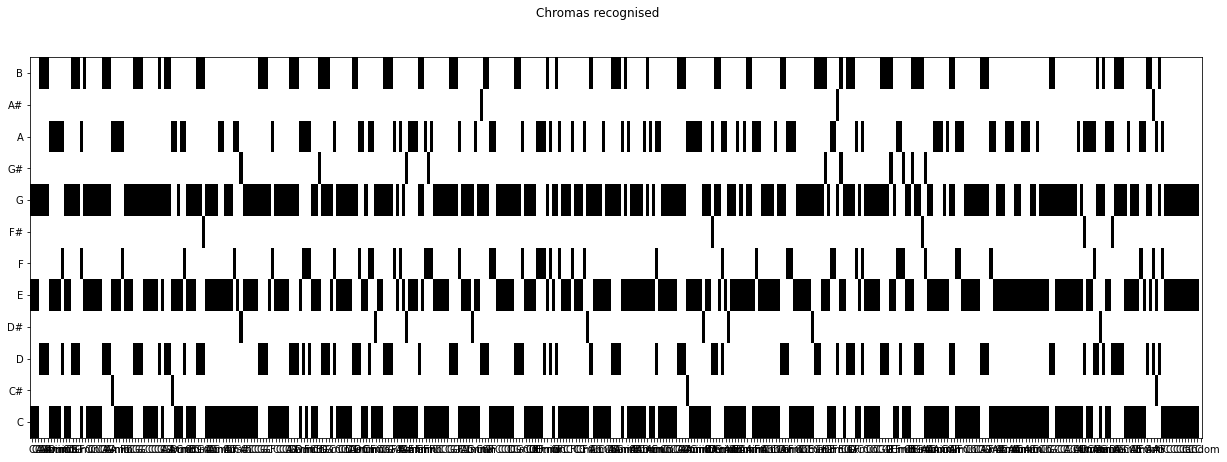

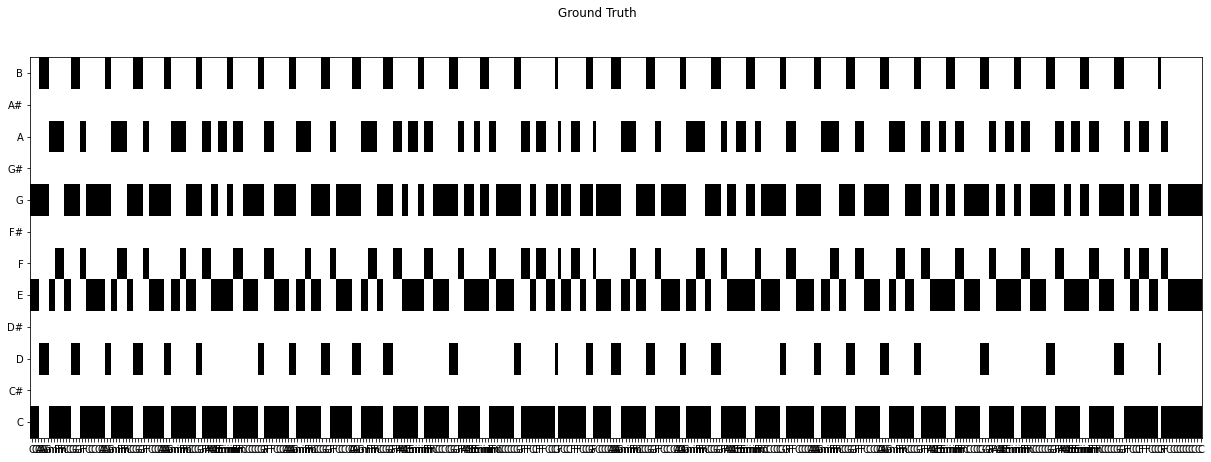

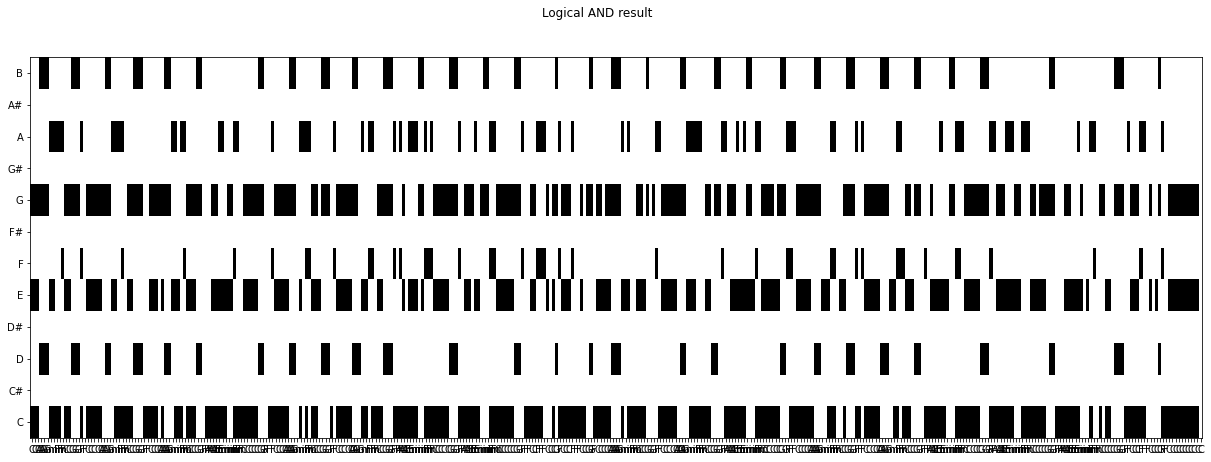

In [20]:
# TEST CHECK ON LET IT BE

fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
letit = "./data/csv/Beatles_LetItBe.csv"

chordListValue, Fs_featureVal, chords_sim, chords_max = computeChordListEval(fn_wav, smoothing_window_length=7, smoothing_down_sampling=7)
let_it_be_list, end,correction_flag = loadCSV(letit, Fs_featureVal,len(chordListValue))

stripped_list = stripList (let_it_be_list, chroma_labels)
print(stripped_list)
isCorrect = correct_strip_check(stripped_list, chroma_labels)
print(isCorrect)
goodness1 = compute_goodness(chordListValue, stripped_list)
goodness2, listOfNotes = compute_goodness_notes_based(chord_list = chordListValue, ground_truth_list = stripped_list, plotChromas = True)
print('Goodness on total correct chords: '+ str(goodness1))
print('Goodness on total correct notes: '+ str(goodness2))
compute_mismatch_matrix(chordListValue,stripped_list,chroma_labels)


## Question 4   


In [21]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
songs= ['HereComesTheSun','LetItBe','ObLaDiObLaDa','PennyLane']
for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    #print(wavFile)
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    #print(sourceWav)
    computedChordList, Fs_feature, chords_sim, chords_max = computeChordListEval(sourceWav, smoothing_window_length=7, smoothing_down_sampling=7)
    ground_truth_List, timeLength,correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
    ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
    metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
    metric_value2, commonNotesList = compute_goodness_notes_based(computedChordList, ground_truth_List_stripped)
    print(title + " metric goodness: " + str(metric_value))
    print(title + " metric goodness note based: " + str(metric_value2))
    print()

HereComesTheSun metric goodness: 0.583916083916084
HereComesTheSun metric goodness note based: 0.7773892773892774

LetItBe metric goodness: 0.632
LetItBe metric goodness note based: 0.808

ObLaDiObLaDa metric goodness: 0.6185567010309279
ObLaDiObLaDa metric goodness note based: 0.8029782359679267

PennyLane metric goodness: 0.5406360424028268
PennyLane metric goodness note based: 0.773851590106007



## Question 5
In this section are produced a set of different metrics based on the variation of different parameters, one at time, in the chord evaluation algorithm.

#### In the following cell the smoothing window length is variable within values [0, 10, 20]


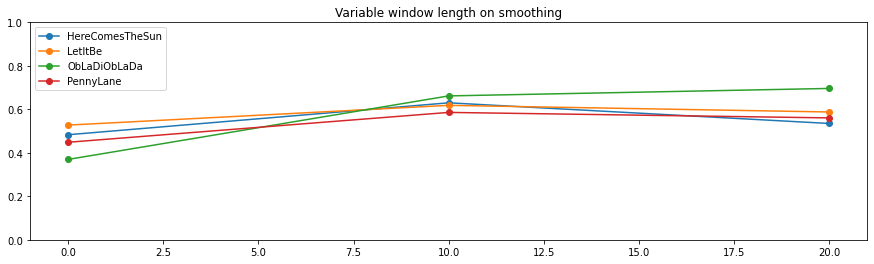

In [22]:

chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
songs= ['HereComesTheSun','LetItBe','ObLaDiObLaDa','PennyLane']
metric_matrix = np.zeros((3,3))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 10*i,
                                                                                                 smoothing_down_sampling = 10)
        ground_truth_List, timeLength,correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(10*k, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable window length on smoothing')
plt.show()

#### In the following cell the downsampling factor is variable within values [0, 10, 20]


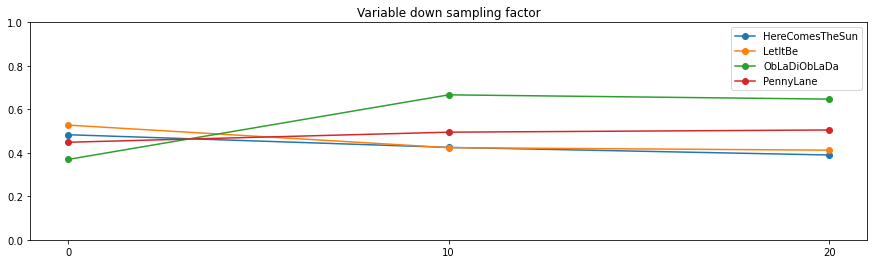

In [23]:

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 41,
                                                                                                 smoothing_down_sampling = 10*i)
        ground_truth_List, timeLength,correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(10*k, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable down sampling factor')
plt.xticks(10*np.arange(3),10*np.arange(3))
plt.show()

##### In the following cell the window shape in smoothing/downsampling algorithm can take boxcar, triangular or hann shape


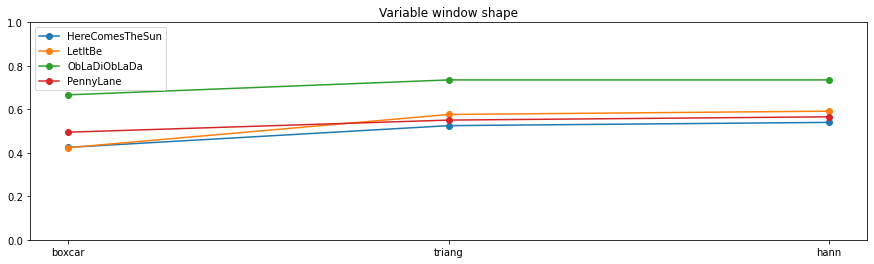

In [24]:

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
windows = ['boxcar', 'triang', 'hann']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, smoothing_window_length = 41,
                                                                                                 smoothing_down_sampling = 10, window_type = windows[i])
        ground_truth_List, timeLength,correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    k = np.arange(3)
    plt.plot(windows, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable window shape')
plt.xticks(windows,windows)
plt.show()

#### In the following cell the normalizing factor in input has been varied in the range of possibile values ['1', '2', 'max']

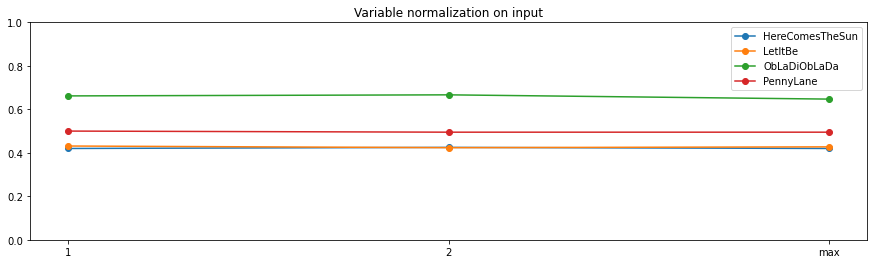

In [25]:

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
norm = ['1', '2', 'max']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = norm[i])
        ground_truth_List, timeLength,correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(norm, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable normalization on input')
plt.xticks(norm,norm)
plt.show()

#### In the following cell the normalizing factor in output has been varied in the range of possibile values ['1', '2', 'max']

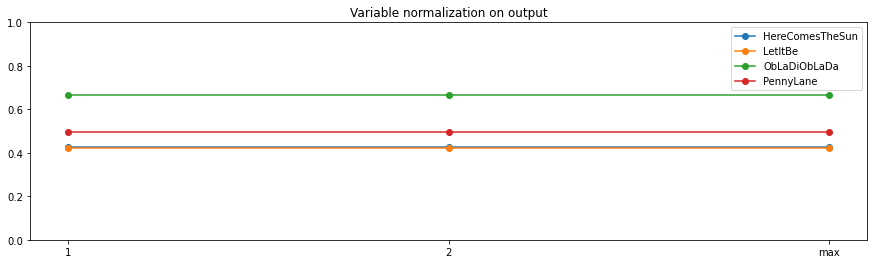

In [26]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
norm = ['1', '2', 'max']

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = norm[i])
        ground_truth_List, timeLength, correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(norm, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable normalization on output')
plt.xticks(norm,norm)
plt.show()

#### In the following cell one has been varied the STFT length in samples between values [1024, 2048, 4096]

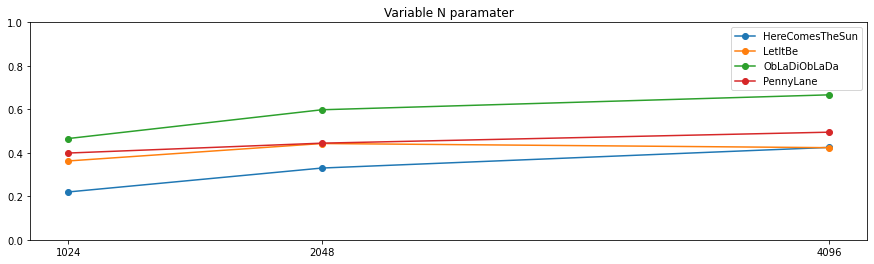

In [27]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
spls = [1024, 2048, 4096]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    N = spls[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength, correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(spls, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable N paramater')
plt.xticks(spls,spls)
plt.show()

#### In the following cell one has been varied the hop size between values [512, 1024, 2048]

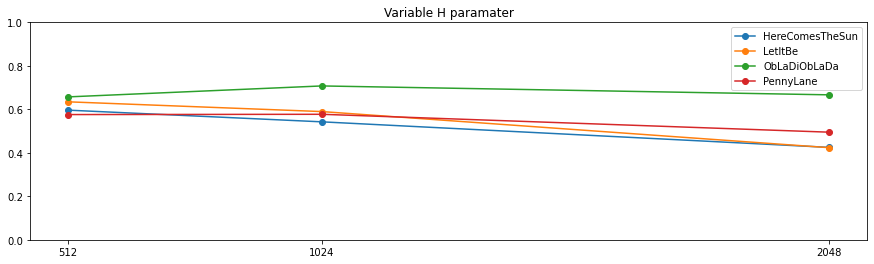

In [28]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
spls = [512, 1024, 2048]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    H = spls[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength, correction_flag = loadCSV(sourceCSV,Fs_feature,len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(spls, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable H paramater')
plt.xticks(spls,spls)
plt.show()

#### In this cell the sample rate used to compute the chromagram has been varied between values [11025, 22050, 44100]

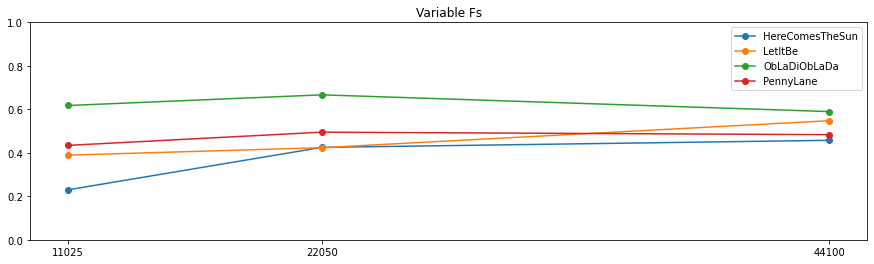

In [29]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_ylim(0,1)
freq = [11025, 22050, 44100]

for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    metric_values = []
    
    for i in range(3):
        computedChordList, Fs_feature, chord_sim, chord_max = computeChordListEval(sourceWav, 
                                                                                    Fs = freq[i],
                                                                                    smoothing_window_length = 41,
                                                                                    smoothing_down_sampling = 10,
                                                                                    window_type = 'boxcar',
                                                                                    norm_chromagram = '2',
                                                                                    norm_output = 'max')
        ground_truth_List, timeLength, correction_flag = loadCSV(sourceCSV, Fs_feature, len(computedChordList))
        ground_truth_List_stripped = stripList(ground_truth_List, chroma_labels_names)
        metric_value = compute_goodness(computedChordList, ground_truth_List_stripped)
        metric_values.append(metric_value)
    # k = np.arange(3)
    plt.plot(freq, metric_values, '-o')

ax.legend(songs)
ax.set_title('Variable Fs')
plt.xticks(freq,freq)
plt.show()